<a href="https://colab.research.google.com/github/Mahdi-Abdollahii/Dusty-Stellar-Sources-Classification/blob/main/Reg_file_DSS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading data from GitHub


The project is hosted on GitHub. Get a copy by running:

In [1]:
!git clone https://github.com/Mahdi-Abdollahii/Dusty-Stellar-Sources-Classification.git

Cloning into 'Dusty-Stellar-Sources-Classification'...
remote: Enumerating objects: 106, done.
remote: Counting objects: 100% (106/106), done.
remote: Compressing objects: 100% (102/102), done.
remote: Total 106 (delta 47), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (106/106), 12.06 MiB | 10.36 MiB/s, done.
Resolving deltas: 100% (47/47), done.


In [2]:
!pip install pyunpack

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install patool

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 KB 2.8 MB/s eta 0:00:00


# Libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io, requests, zipfile
from zipfile import ZipFile
import seaborn as sns
from sklearn.metrics import confusion_matrix , accuracy_score , recall_score , precision_score , f1_score , classification_report
from pyunpack import Archive
import warnings
warnings.filterwarnings('ignore')

# Data Preprocessing


## **SMC**

In [5]:
from astropy.io import fits

a = fits.open('/content/Dusty-Stellar-Sources-Classification/Data/J_MNRAS_451_3504_table2.dat.fits')
a[1].columns['---'].name = 'new_name1'
a[1].columns['---'].name = 'new_name2'
a[1].columns['---'].name = 'new_name3'
a[1].columns['---'].name = 'new_name4'
a[1].columns['---'].name = 'new_name5'
a[1].columns['---'].name = 'new_name6'

smc = pd.DataFrame(a[1].data)
smc['Class'].value_counts()

C-AGB                    39
STAR: dusty OB star      23
YSO-3                    22
RSG                      22
C-PN                     20
YSO-1                    14
O-AGB                    11
WR                       10
YSO-4                    10
O-EAGB                    8
YSO-2                     5
O-PN                      4
STAR                      4
RCrB                      3
C-PAGB                    3
HII                       3
OTHER: B[e] star          2
OTHER: FG O-EAGB          2
OTHER: S Star             1
O-PAGB                    1
OTHER: symbiotic star     1
BSG                       1
Name: Class, dtype: int64

In [6]:
smc = smc[['RAdeg','DEdeg','UMmag','BMmag','VMmag','IMmag','<Vmag>','<Imag>','Iamp','P2','J2mag',
         'H2mag','Ks2mag','JImag','HImag','KImag','IRAC1','IRAC2','IRAC3','IRAC4',
         '[24]','[70]','[160]','Tmcd','Class']]

smc = smc.rename(columns={'UMmag':'Umag','BMmag':'Bmag','VMmag':'Vmag','IMmag':'Imag','Iamp':'IAmp',
                           'P2':'Per','JImag':'Jmag','HImag':'Hmag','KImag':'Ksmag','IRAC1':'[3.6]',
                           'IRAC2':'[4.5]','IRAC3':'[5.8]','IRAC4':'[8.0]','Tmcd':'TeffMcD' , 'Class': 'SpClass'})

In [7]:
for i in smc.index:
  x = smc.loc[i , 'SpClass']
  l = list(x.replace(' ','*'))
  smc.loc[i , 'SpClass'] = ''.join([s for s in l if s != '*'])

In [8]:
smc['SpClass'] = smc['SpClass'].replace({'YSO-1':'YSO','O-EAGB':'OAGB',
                                 'YSO-2':'YSO','O-AGB':'OAGB',
                                 'YSO-3':'YSO','RSG':'RSG',
                                 'YSO-4':'YSO','C-AGB':'CAGB',
                                 'O-PAGB':'PAGB','C-PAGB':'PAGB'})

In [9]:
list_Class_DSS = ['YSO' , 'PAGB' , 'OAGB' , 'RSG' , 'CAGB']
smc['GeneralClass'] = np.nan
for i in smc.index:
  if smc.loc[i,'SpClass'] in list_Class_DSS :
    smc.loc[i,'GeneralClass'] = 'DSS'
  else :
    smc.loc[i,'GeneralClass'] = 'Other'

In [10]:
smc.replace([np.inf, -np.inf, -99, 99.999 , 0.00 ], np.nan, inplace=True)

In [11]:
F_list = smc.columns.drop(['TeffMcD','Per','IAmp'])
SMC_DM = 18.96  # https://arxiv.org/abs/1502.06995
for i in F_list[2:-2] :
  smc[i] = smc[i] - SMC_DM

In [12]:
smc

,RAdeg,DEdeg,Umag,Bmag,Vmag,Imag,<Vmag>,<Imag>,IAmp,Per,...,[3.6],[4.5],[5.8],[8.0],[24],[70],[160],TeffMcD,SpClass,GeneralClass
0,14.737258,-72.165012,-1.672,-1.095,-1.483,-1.025,NaN,NaN,NaN,NaN,...,-6.289,-7.547,-8.861,-10.098,-14.534,NaN,-23.648,NaN,YSO,DSS
1,14.772992,-72.176654,-4.925,-3.913,-3.322,-4.047,-1.359,-3.719,0.02,23.0,...,-8.859,-9.538,-10.246,-11.726,-17.599,-20.672,NaN,NaN,YSO,DSS
2,14.774849,-72.190814,-4.126,-3.003,-3.354,-3.720,NaN,NaN,NaN,NaN,...,-8.415,-9.199,-10.033,-10.980,-12.909,NaN,NaN,NaN,YSO,DSS
3,14.788491,-72.182480,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-8.897,-10.099,-11.136,-12.149,-16.759,-20.459,NaN,NaN,YSO,DSS
4,14.801191,-72.166181,-3.719,-2.324,-3.003,-3.536,NaN,NaN,NaN,NaN,...,-6.986,-7.582,-8.538,-10.139,-15.583,-20.251,NaN,NaN,YSO,DSS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,14.488457,-72.654396,-1.433,-0.683,-1.165,-1.937,NaN,NaN,NaN,NaN,...,-6.686,-7.273,-8.261,-9.226,-15.289,-20.521,NaN,NaN,YSO,DSS
205,14.027887,-72.789808,-1.445,-1.084,-1.477,-2.014,NaN,NaN,NaN,NaN,...,-5.481,-5.975,-7.743,-9.168,-15.340,-19.318,-21.974,NaN,YSO,DSS
206,16.039817,-72.837738,-2.197,-3.746,-5.564,NaN,NaN,NaN,NaN,NaN,...,-9.699,-9.711,-9.922,-10.050,-10.804,NaN,NaN,3150.0,OAGB,DSS
207,11.378159,-73.082106,-3.391,-2.611,-2.893,-2.998,NaN,NaN,NaN,NaN,...,NaN,-5.366,-7.286,-8.732,-14.765,-20.172,NaN,NaN,HII,Other


(array([135.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,  74.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

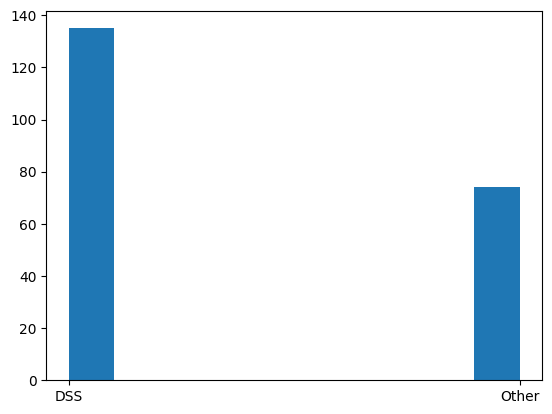

In [13]:
plt.hist(smc['GeneralClass'])

(array([51.,  0., 19.,  0.,  0., 39.,  0., 22.,  0.,  4.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

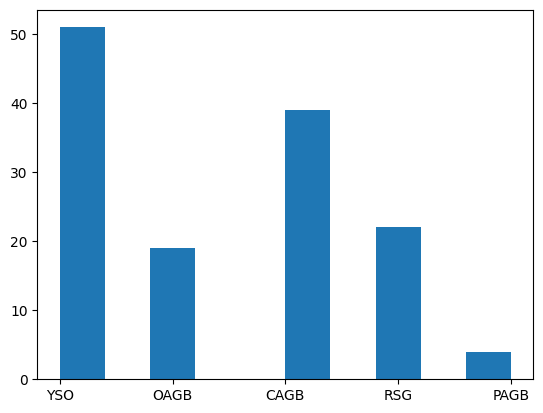

In [14]:
plt.hist(smc[smc['GeneralClass'] == 'DSS']['SpClass'])

----
## **LMC**

In [15]:
from astropy.io import fits
import pandas as pd
with fits.open('/content/Dusty-Stellar-Sources-Classification/Data/J_MNRAS_470_3250_table2.dat.fits') as data:
    lmc = pd.DataFrame(data[1].data)

lmc['SpClass'].value_counts()

     HII    155
    CAGB    152
    OAGB     89
    YSO3     81
     RSG     72
    YSO1     56
HII/YSO3     37
    STAR     31
     OPN     28
    YSO4     23
   CPAGB     19
    YSO2     16
     LBV     15
   OPAGB     14
     CPN     14
      WR     11
   RVTau     10
    B[e]      9
     GAL      8
     SNR      7
    RCrB      6
     UNK      5
     BSG      2
    Nova      1
     YSG      1
Name: SpClass, dtype: int64

In [16]:
lmc = lmc[['RAdeg','DEdeg','Umag','Bmag','Vmag','Imag','<Vmag>','<Imag>','IAmp','Per','J2mag',
         'H2mag','Ks2mag','Jmag','Hmag','Ksmag','[3.6]','[4.5]','[5.8]','[8.0]',
         '[24]','[70]','[160]','TeffMcD','SpClass']]

In [17]:
for i in lmc.index:
  x = lmc.loc[i , 'SpClass']
  l = list(x.replace(' ','*'))
  lmc.loc[i , 'SpClass'] = ''.join([s for s in l if s != '*'])

In [18]:
lmc

,RAdeg,DEdeg,Umag,Bmag,Vmag,Imag,<Vmag>,<Imag>,IAmp,Per,...,Ksmag,[3.6],[4.5],[5.8],[8.0],[24],[70],[160],TeffMcD,SpClass
0,69.3381,-70.5790,-99.000,18.307,16.468,13.943,16.623,13.985,0.057,100.76,...,-99.00,10.9099,10.8052,10.6874,10.5041,9.6408,-99.000,-99.000,3156.0,OAGB
1,69.3653,-67.9097,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.00,...,-99.00,14.0148,13.5151,13.0565,10.1457,7.0279,1.476,-99.000,-99.0,GAL
2,71.6131,-68.7963,20.152,20.746,19.051,16.383,19.386,16.401,1.573,388.70,...,10.68,9.8544,9.1327,8.7100,8.2771,7.3256,-99.000,-99.000,-99.0,CAGB
3,71.8277,-69.7057,17.793,15.644,13.716,11.300,-99.000,-99.000,-99.000,-99.00,...,-99.00,8.8660,9.0441,8.8655,8.7573,7.5515,-99.000,-99.000,3270.0,RSG
4,72.1573,-69.3936,-99.000,21.970,20.987,19.656,-99.000,-99.000,-99.000,-99.00,...,13.21,10.3666,9.4821,8.6769,7.8657,4.8646,-99.000,-99.000,-99.0,YSO2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,92.6059,-67.9392,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.00,...,-99.00,-99.0000,-99.0000,-99.0000,-99.0000,5.8112,-99.000,-99.000,-99.0,OPN
858,74.1082,-66.5322,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.00,...,-99.00,-99.0000,-99.0000,-99.0000,-99.0000,4.0541,-99.000,-5.032,-99.0,HII
859,81.1610,-70.3992,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.000,-99.00,...,13.80,9.4577,8.3001,7.2930,6.4067,4.6280,-99.000,-99.000,-99.0,CAGB
860,83.2786,-70.5095,-99.000,19.339,18.744,-99.000,-99.000,-99.000,-99.000,-99.00,...,14.08,9.9564,8.5741,7.4169,6.3789,4.4096,-99.000,-99.000,-99.0,CAGB


In [19]:
lmc['SpClass'] = lmc['SpClass'].replace({'OAGB': 'OAGB','CAGB': 'CAGB','YSO1':'YSO',
                                     'YSO2':'YSO','YSO3':'YSO','CPAGB':'PAGB',
                                     'OPAGB':'PAGB','HII/YSO3':'YSO','YSO4':'YSO',
                                     'RSG':'RSG'})

In [20]:
list_Class_DSS = ['YSO' , 'PAGB' , 'OAGB' , 'RSG' , 'CAGB']
lmc['GeneralClass'] = np.nan
for i in lmc.index:
  if lmc.loc[i,'SpClass'] in list_Class_DSS :
    lmc.loc[i,'GeneralClass'] = 'DSS'
  else :
    lmc.loc[i,'GeneralClass'] = 'Other'

In [21]:
lmc.replace([np.inf, -np.inf, -99, 99.999 , 0.00 ], np.nan, inplace=True)

In [22]:
F_list = lmc.columns.drop(['TeffMcD','Per','IAmp'])
LMC_DM = 18.52 # https://arxiv.org/abs/astro-ph/0011056
for i in F_list[2:-2] :
  lmc[i] = lmc[i] - LMC_DM

In [23]:
lmc

,RAdeg,DEdeg,Umag,Bmag,Vmag,Imag,<Vmag>,<Imag>,IAmp,Per,...,[3.6],[4.5],[5.8],[8.0],[24],[70],[160],TeffMcD,SpClass,GeneralClass
0,69.3381,-70.5790,NaN,-0.213,-2.052,-4.577,-1.897,-4.535,0.057,100.76,...,-7.6101,-7.7148,-7.8326,-8.0159,-8.8792,NaN,NaN,3156.0,OAGB,DSS
1,69.3653,-67.9097,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-4.5052,-5.0049,-5.4635,-8.3743,-11.4921,-17.044,NaN,NaN,GAL,Other
2,71.6131,-68.7963,1.632,2.226,0.531,-2.137,0.866,-2.119,1.573,388.70,...,-8.6656,-9.3873,-9.8100,-10.2429,-11.1944,NaN,NaN,NaN,CAGB,DSS
3,71.8277,-69.7057,-0.727,-2.876,-4.804,-7.220,NaN,NaN,NaN,NaN,...,-9.6540,-9.4759,-9.6545,-9.7627,-10.9685,NaN,NaN,3270.0,RSG,DSS
4,72.1573,-69.3936,NaN,3.450,2.467,1.136,NaN,NaN,NaN,NaN,...,-8.1534,-9.0379,-9.8431,-10.6543,-13.6554,NaN,NaN,NaN,YSO,DSS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857,92.6059,-67.9392,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-12.7088,NaN,NaN,NaN,OPN,Other
858,74.1082,-66.5322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,-14.4659,NaN,-23.552,NaN,HII,Other
859,81.1610,-70.3992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-9.0623,-10.2199,-11.2270,-12.1133,-13.8920,NaN,NaN,NaN,CAGB,DSS
860,83.2786,-70.5095,NaN,0.819,0.224,NaN,NaN,NaN,NaN,NaN,...,-8.5636,-9.9459,-11.1031,-12.1411,-14.1104,NaN,NaN,NaN,CAGB,DSS


(array([559.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 303.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

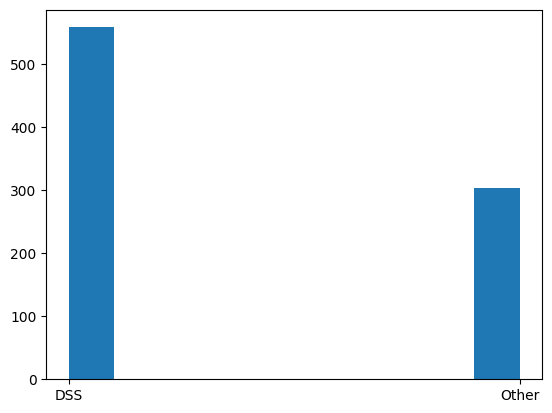

In [24]:
plt.hist(lmc['GeneralClass'])

(array([ 89.,   0., 152.,   0.,   0.,  72.,   0., 213.,   0.,  33.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

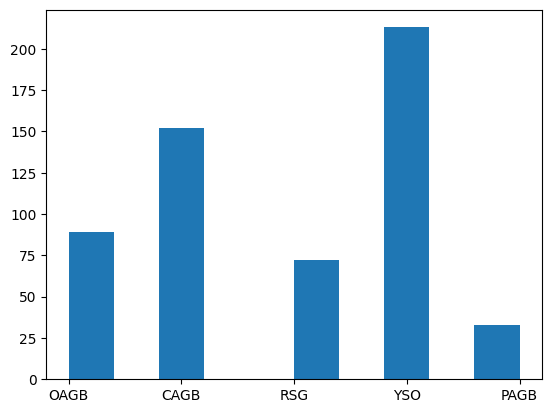

In [25]:
plt.hist(lmc[lmc['GeneralClass'] == 'DSS']['SpClass'])

# Data Cleaning -> Previous data cleaning + Rmoving some columns which have all correlation with others.



In [26]:
lmc_ALL = lmc[lmc['GeneralClass'] == 'DSS']
lmc_ALL['loc'] = 'LMC'
smc_ALL = smc[smc['GeneralClass'] == 'DSS']
smc_ALL['loc'] = 'SMC'
df = pd.concat([lmc_ALL,smc_ALL])
df = df.reset_index(drop=True)

In [27]:
df

,RAdeg,DEdeg,Umag,Bmag,Vmag,Imag,<Vmag>,<Imag>,IAmp,Per,...,[4.5],[5.8],[8.0],[24],[70],[160],TeffMcD,SpClass,GeneralClass,loc
0,69.338100,-70.579000,NaN,-0.213,-2.052,-4.577,-1.897,-4.535,0.057,100.76,...,-7.7148,-7.8326,-8.0159,-8.8792,NaN,NaN,3156.0,OAGB,DSS,LMC
1,71.613100,-68.796300,1.632,2.226,0.531,-2.137,0.866,-2.119,1.573,388.70,...,-9.3873,-9.8100,-10.2429,-11.1944,NaN,NaN,NaN,CAGB,DSS,LMC
2,71.827700,-69.705700,-0.727,-2.876,-4.804,-7.220,NaN,NaN,NaN,NaN,...,-9.4759,-9.6545,-9.7627,-10.9685,NaN,NaN,3270.0,RSG,DSS,LMC
3,72.157300,-69.393600,NaN,3.450,2.467,1.136,NaN,NaN,NaN,NaN,...,-9.0379,-9.8431,-10.6543,-13.6554,NaN,NaN,NaN,YSO,DSS,LMC
4,72.393200,-69.097000,-5.087,-4.936,-5.254,-5.992,NaN,NaN,NaN,NaN,...,-8.9152,-9.2952,-9.9431,-11.3106,NaN,NaN,5555.0,OAGB,DSS,LMC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689,14.527078,-72.068717,-0.459,-0.388,-0.926,-1.672,NaN,NaN,NaN,NaN,...,-5.6600,-8.0320,-9.6220,-15.6450,-19.630,NaN,NaN,YSO,DSS,SMC
690,14.488457,-72.654396,-1.433,-0.683,-1.165,-1.937,NaN,NaN,NaN,NaN,...,-7.2730,-8.2610,-9.2260,-15.2890,-20.521,NaN,NaN,YSO,DSS,SMC
691,14.027887,-72.789808,-1.445,-1.084,-1.477,-2.014,NaN,NaN,NaN,NaN,...,-5.9750,-7.7430,-9.1680,-15.3400,-19.318,-21.974,NaN,YSO,DSS,SMC
692,16.039817,-72.837738,-2.197,-3.746,-5.564,NaN,NaN,NaN,NaN,NaN,...,-9.7110,-9.9220,-10.0500,-10.8040,NaN,NaN,3150.0,OAGB,DSS,SMC


In [28]:
print( f"The number of records are : {df.shape[0]} ")
print( f"The number of columns are : {df.shape[1]} ")

The number of records are : 694 
The number of columns are : 27 


In [29]:
df.dtypes

RAdeg           float64
DEdeg           float64
Umag            float64
Bmag            float64
Vmag            float64
Imag            float64
<Vmag>          float64
<Imag>          float64
IAmp            float64
Per             float64
J2mag           float64
H2mag           float64
Ks2mag          float64
Jmag            float64
Hmag            float64
Ksmag           float64
[3.6]           float64
[4.5]           float64
[5.8]           float64
[8.0]           float64
[24]            float64
[70]            float64
[160]           float64
TeffMcD         float64
SpClass          object
GeneralClass     object
loc              object
dtype: object

In [30]:
nan_data_point = df.iloc[:,2:-2].isnull().sum().sum()
all_data_point = df.iloc[:,2:-2].shape[0]*df.iloc[:,2:-2].shape[1]
missing_fraction = nan_data_point / all_data_point

print(f'There are {all_data_point} data points in this data')
print(f'There are {nan_data_point} missing data in this data')
print(f'The fraction of missing data in all data is {missing_fraction}')

There are 15962 data points in this data
There are 6179 missing data in this data
The fraction of missing data in all data is 0.38710687883723843


So it is shocking that we have 6179 misisng data in this data.
we should find some ways to adapt it.

The first suggestion is finding and removing some columns which have incredible nan data

In [31]:
#Checking for total null values
df.iloc[:,2:-2].isnull().sum()

Umag       381
Bmag       285
Vmag       285
Imag       356
<Vmag>     550
<Imag>     512
IAmp       515
Per        512
J2mag      146
H2mag       99
Ks2mag      75
Jmag       159
Hmag       164
Ksmag      215
[3.6]       89
[4.5]       52
[5.8]       42
[8.0]       73
[24]        40
[70]       506
[160]      617
TeffMcD    506
SpClass      0
dtype: int64

We find out 7 columns have more than 500 nan value. So we delet this columns and continue with others.

In [32]:
more_than_500_nan = []
for i in df.columns[2:-3]:
  if np.count_nonzero(np.isnan(np.array(df[i]))) > 500 :
    more_than_500_nan.append(i)

print(more_than_500_nan)

['<Vmag>', '<Imag>', 'IAmp', 'Per', '[70]', '[160]', 'TeffMcD']


In [33]:
df.drop(more_than_500_nan, inplace=True, axis=1)

In [34]:
df.drop(['J2mag','H2mag','Ks2mag'], inplace=True, axis=1)

In [35]:
df

,RAdeg,DEdeg,Umag,Bmag,Vmag,Imag,Jmag,Hmag,Ksmag,[3.6],[4.5],[5.8],[8.0],[24],SpClass,GeneralClass,loc
0,69.338100,-70.579000,NaN,-0.213,-2.052,-4.577,NaN,NaN,NaN,-7.6101,-7.7148,-7.8326,-8.0159,-8.8792,OAGB,DSS,LMC
1,71.613100,-68.796300,1.632,2.226,0.531,-2.137,-5.04,-6.57,-7.84,-8.6656,-9.3873,-9.8100,-10.2429,-11.1944,CAGB,DSS,LMC
2,71.827700,-69.705700,-0.727,-2.876,-4.804,-7.220,-8.42,NaN,NaN,-9.6540,-9.4759,-9.6545,-9.7627,-10.9685,RSG,DSS,LMC
3,72.157300,-69.393600,NaN,3.450,2.467,1.136,-1.32,-3.37,-5.31,-8.1534,-9.0379,-9.8431,-10.6543,-13.6554,YSO,DSS,LMC
4,72.393200,-69.097000,-5.087,-4.936,-5.254,-5.992,-6.39,-6.86,-7.42,-8.4329,-8.9152,-9.2952,-9.9431,-11.3106,OAGB,DSS,LMC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
689,14.527078,-72.068717,-0.459,-0.388,-0.926,-1.672,-2.36,-2.83,-3.27,-5.5270,-5.6600,-8.0320,-9.6220,-15.6450,YSO,DSS,SMC
690,14.488457,-72.654396,-1.433,-0.683,-1.165,-1.937,-2.42,-3.14,-4.14,-6.6860,-7.2730,-8.2610,-9.2260,-15.2890,YSO,DSS,SMC
691,14.027887,-72.789808,-1.445,-1.084,-1.477,-2.014,-2.74,-3.09,-3.23,-5.4810,-5.9750,-7.7430,-9.1680,-15.3400,YSO,DSS,SMC
692,16.039817,-72.837738,-2.197,-3.746,-5.564,NaN,NaN,NaN,NaN,-9.6990,-9.7110,-9.9220,-10.0500,-10.8040,OAGB,DSS,SMC


Now we calculate previous information again

In [36]:
nan_data_point = df.iloc[:,2:-2].isnull().sum().sum()
all_data_point = df.iloc[:,2:-2].shape[0]*df.iloc[:,2:-2].shape[1]
missing_fraction = nan_data_point / all_data_point

print(f'There are {all_data_point} data points in this data')
print(f'There are {nan_data_point} missing data in this data')
print(f'The fraction of missing data in all data is {missing_fraction}')

There are 9022 data points in this data
There are 2141 missing data in this data
The fraction of missing data in all data is 0.23730880070937707


In the next step we should find the number of missing values in for each stars.

In [37]:
list_row_nan = []
list_Class = []
list_row_nan_6 = []
list_Class_6 = []
list_index_6 = []
for i in range(0,len(df)):
  count_nan = df.iloc[i].isnull().sum()
  list_row_nan.append(count_nan)
  if count_nan > 6 :    
    list_row_nan_6.append(count_nan)
    list_Class_6.append(df.iloc[i][-3])
    list_index_6.append(i)

(array([56.,  0., 17.,  0.,  0.,  6.,  0.,  4.,  0.,  3.]),
 array([ 7. ,  7.4,  7.8,  8.2,  8.6,  9. ,  9.4,  9.8, 10.2, 10.6, 11. ]),
 <BarContainer object of 10 artists>)

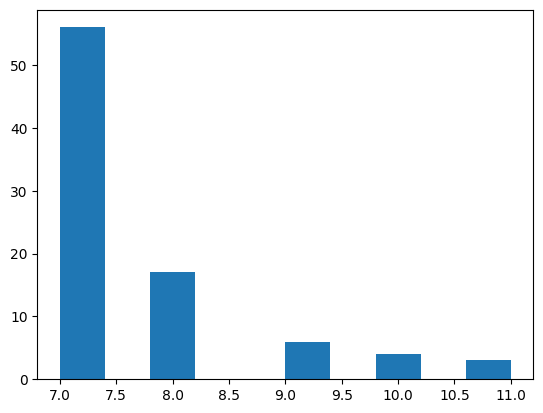

In [38]:
plt.hist(list_row_nan_6)

In [39]:
sum(list_row_nan_6)

655

In [40]:
len(list_row_nan_6)

86

(array([[ 25.,   0.,   9.,   0.,   0.,  37.,   0.,  15.,   0.,   0.],
        [191.,   0., 108.,   0.,   0., 264.,   0.,  94.,   0.,  37.]]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 2 BarContainer objects>)

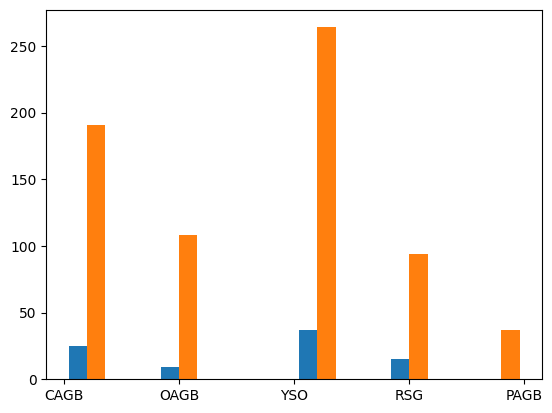

In [41]:
plt.hist([list_Class_6,df['SpClass']])

In [42]:
df.drop(list_index_6, axis=0, inplace=True)
df = df.reset_index(drop=True)

In [43]:
nan_data_point = df.iloc[:,2:-2].isnull().sum().sum()
all_data_point = df.iloc[:,2:-2].shape[0]*df.iloc[:,2:-2].shape[1]
missing_fraction = nan_data_point / all_data_point

print(f'There are {all_data_point} data points in this data')
print(f'There are {nan_data_point} missing data in this data')
print(f'The fraction of missing data in all data is {missing_fraction}')

There are 7904 data points in this data
There are 1486 missing data in this data
The fraction of missing data in all data is 0.18800607287449392


(array([ 99.,   0., 166.,   0.,   0.,  79.,   0., 227.,   0.,  37.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

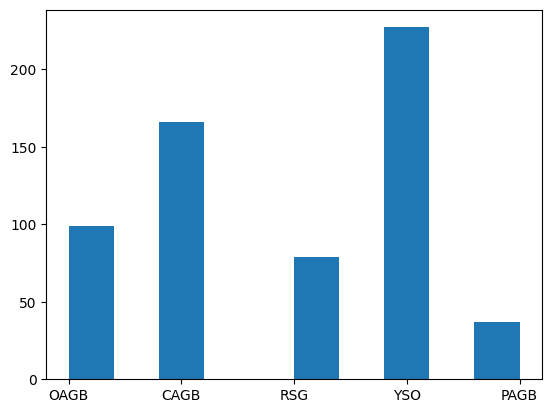

In [44]:
plt.hist(df['SpClass'])

DSS


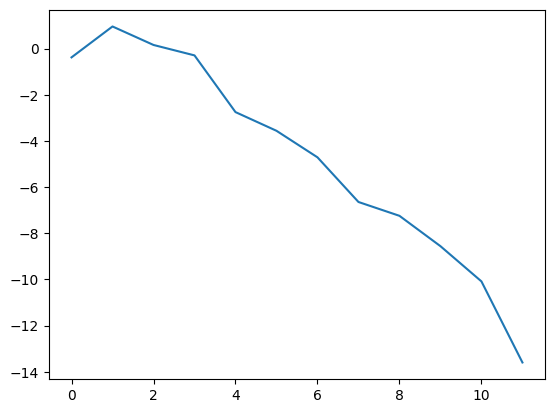

In [45]:
star_number = 70
plt.plot(np.array(df.iloc[star_number][2:-3]))
print(df.iloc[star_number][-2])

In [46]:
df

,RAdeg,DEdeg,Umag,Bmag,Vmag,Imag,Jmag,Hmag,Ksmag,[3.6],[4.5],[5.8],[8.0],[24],SpClass,GeneralClass,loc
0,69.338100,-70.579000,NaN,-0.213,-2.052,-4.577,NaN,NaN,NaN,-7.6101,-7.7148,-7.8326,-8.0159,-8.8792,OAGB,DSS,LMC
1,71.613100,-68.796300,1.632,2.226,0.531,-2.137,-5.04,-6.57,-7.84,-8.6656,-9.3873,-9.8100,-10.2429,-11.1944,CAGB,DSS,LMC
2,71.827700,-69.705700,-0.727,-2.876,-4.804,-7.220,-8.42,NaN,NaN,-9.6540,-9.4759,-9.6545,-9.7627,-10.9685,RSG,DSS,LMC
3,72.157300,-69.393600,NaN,3.450,2.467,1.136,-1.32,-3.37,-5.31,-8.1534,-9.0379,-9.8431,-10.6543,-13.6554,YSO,DSS,LMC
4,72.393200,-69.097000,-5.087,-4.936,-5.254,-5.992,-6.39,-6.86,-7.42,-8.4329,-8.9152,-9.2952,-9.9431,-11.3106,OAGB,DSS,LMC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603,15.093451,-72.166074,-0.232,0.796,0.248,-0.445,NaN,-2.54,-4.04,-6.3120,-7.3400,-8.2350,-9.4640,-13.6900,YSO,DSS,SMC
604,14.527078,-72.068717,-0.459,-0.388,-0.926,-1.672,-2.36,-2.83,-3.27,-5.5270,-5.6600,-8.0320,-9.6220,-15.6450,YSO,DSS,SMC
605,14.488457,-72.654396,-1.433,-0.683,-1.165,-1.937,-2.42,-3.14,-4.14,-6.6860,-7.2730,-8.2610,-9.2260,-15.2890,YSO,DSS,SMC
606,14.027887,-72.789808,-1.445,-1.084,-1.477,-2.014,-2.74,-3.09,-3.23,-5.4810,-5.9750,-7.7430,-9.1680,-15.3400,YSO,DSS,SMC


# Making reg file

In [47]:
pip install git+https://github.com/Mahdi-Abdollahii/AstroDC.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/Mahdi-Abdollahii/AstroDC.git to /tmp/pip-req-build-6bepd_37
  Running command git clone --filter=blob:none --quiet https://github.com/Mahdi-Abdollahii/AstroDC.git /tmp/pip-req-build-6bepd_37
  Resolved https://github.com/Mahdi-Abdollahii/AstroDC.git to commit 4bafb54a16036db236f429814d8bc2fad30cc07f
  Preparing metadata (setup.py) ... done
  Created wheel for AstroDC: filename=AstroDC-1.0.4-py3-none-any.whl size=2574 sha256=6587a384ae7dfd3b50272ac1164805226fd0020e825e25d22eeae1a451250970
  Stored in directory: /tmp/pip-ephem-wheel-cache-q_0l0wp1/wheels/22/e9/d8/3e2ea76c885e9414f4915871d51adccd8aa853a81eaa9f492d
Successfully built AstroDC


In [48]:
from astropy import units
from AstroDC import AstroDC

##LMC

In [49]:
df_lmc = df[df['loc'] == 'LMC']

In [50]:
df_lmc

,RAdeg,DEdeg,Umag,Bmag,Vmag,Imag,Jmag,Hmag,Ksmag,[3.6],[4.5],[5.8],[8.0],[24],SpClass,GeneralClass,loc
0,69.3381,-70.5790,NaN,-0.213,-2.052,-4.577,NaN,NaN,NaN,-7.6101,-7.7148,-7.8326,-8.0159,-8.8792,OAGB,DSS,LMC
1,71.6131,-68.7963,1.632,2.226,0.531,-2.137,-5.04,-6.57,-7.84,-8.6656,-9.3873,-9.8100,-10.2429,-11.1944,CAGB,DSS,LMC
2,71.8277,-69.7057,-0.727,-2.876,-4.804,-7.220,-8.42,NaN,NaN,-9.6540,-9.4759,-9.6545,-9.7627,-10.9685,RSG,DSS,LMC
3,72.1573,-69.3936,NaN,3.450,2.467,1.136,-1.32,-3.37,-5.31,-8.1534,-9.0379,-9.8431,-10.6543,-13.6554,YSO,DSS,LMC
4,72.3932,-69.0970,-5.087,-4.936,-5.254,-5.992,-6.39,-6.86,-7.42,-8.4329,-8.9152,-9.2952,-9.9431,-11.3106,OAGB,DSS,LMC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475,89.6087,-69.7404,-2.541,-2.476,-3.102,-3.584,NaN,NaN,NaN,-7.1970,-8.1389,-9.6936,-11.7291,-15.4809,PAGB,DSS,LMC
476,90.2131,-66.7443,-3.831,-5.632,-7.068,NaN,NaN,NaN,NaN,-10.9981,-10.9010,-10.9981,-11.0281,-11.1368,OAGB,DSS,LMC
477,91.1063,-67.3884,-5.359,-6.600,-8.462,NaN,NaN,NaN,NaN,-14.0292,-13.8579,-14.0362,-14.1105,-14.3218,RSG,DSS,LMC
478,81.1610,-70.3992,NaN,NaN,NaN,NaN,NaN,-1.97,-4.72,-9.0623,-10.2199,-11.2270,-12.1133,-13.8920,CAGB,DSS,LMC


In [51]:
AstroDC.Reg_file(df_lmc ,'RAdeg','DEdeg', Units = units.deg, Color = 'red', Size = 100, File_name = 'LMC')

LMC.reg file of this data saved in local directory.


In [52]:
colors = ['red','green','blue','magenta','cyan']
SpClass = ['YSO','CAGB','OAGB','RSG','PAGB']
for i in range(len(colors)) :
  df_ = df_lmc[df_lmc['SpClass'] == SpClass[i]]
  color_ = colors[i] 
  File_name_ = 'LMC'+'_'+  SpClass[i]
  AstroDC.Reg_file( df_ ,'RAdeg','DEdeg', Units = units.deg, Color = color_, Size = 100 , File_name = File_name_ )

LMC_YSO.reg file of this data saved in local directory.
LMC_CAGB.reg file of this data saved in local directory.
LMC_OAGB.reg file of this data saved in local directory.
LMC_RSG.reg file of this data saved in local directory.
LMC_PAGB.reg file of this data saved in local directory.


(array([ 81.,   0., 128.,   0.,   0.,  62.,   0., 176.,   0.,  33.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

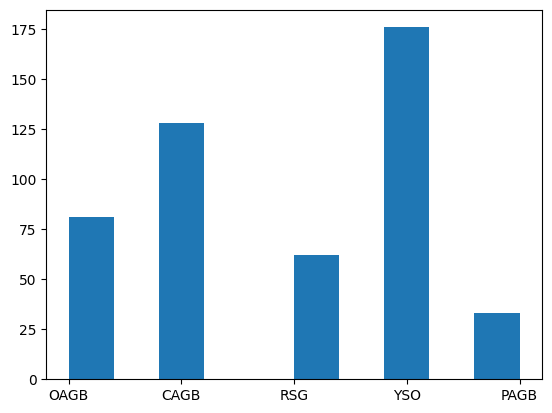

In [53]:
plt.hist(df_lmc['SpClass'])

## SMC

In [54]:
df_smc = df[df['loc'] == 'SMC']

In [55]:
df_smc

,RAdeg,DEdeg,Umag,Bmag,Vmag,Imag,Jmag,Hmag,Ksmag,[3.6],[4.5],[5.8],[8.0],[24],SpClass,GeneralClass,loc
480,14.737258,-72.165012,-1.672,-1.095,-1.483,-1.025,-2.12,-3.07,-3.96,-6.289,-7.547,-8.861,-10.098,-14.534,YSO,DSS,SMC
481,14.772992,-72.176654,-4.925,-3.913,-3.322,-4.047,-4.52,-5.49,-6.79,-8.859,-9.538,-10.246,-11.726,-17.599,YSO,DSS,SMC
482,14.774849,-72.190814,-4.126,-3.003,-3.354,-3.720,-4.43,-5.04,-6.15,-8.415,-9.199,-10.033,-10.980,-12.909,YSO,DSS,SMC
483,14.788491,-72.182480,NaN,NaN,NaN,NaN,-2.65,-4.02,-5.95,-8.897,-10.099,-11.136,-12.149,-16.759,YSO,DSS,SMC
484,14.801191,-72.166181,-3.719,-2.324,-3.003,-3.536,-3.84,-4.37,-5.31,-6.986,-7.582,-8.538,-10.139,-15.583,YSO,DSS,SMC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
603,15.093451,-72.166074,-0.232,0.796,0.248,-0.445,NaN,-2.54,-4.04,-6.312,-7.340,-8.235,-9.464,-13.690,YSO,DSS,SMC
604,14.527078,-72.068717,-0.459,-0.388,-0.926,-1.672,-2.36,-2.83,-3.27,-5.527,-5.660,-8.032,-9.622,-15.645,YSO,DSS,SMC
605,14.488457,-72.654396,-1.433,-0.683,-1.165,-1.937,-2.42,-3.14,-4.14,-6.686,-7.273,-8.261,-9.226,-15.289,YSO,DSS,SMC
606,14.027887,-72.789808,-1.445,-1.084,-1.477,-2.014,-2.74,-3.09,-3.23,-5.481,-5.975,-7.743,-9.168,-15.340,YSO,DSS,SMC


In [56]:
AstroDC.Reg_file(df_smc ,'RAdeg','DEdeg', Units = units.deg, Color = 'red', Size = 100, File_name = 'SMC')

SMC.reg file of this data saved in local directory.


In [57]:
colors = ['red','green','blue','magenta','cyan']
SpClass = ['YSO','CAGB','OAGB','RSG','PAGB']
for i in range(len(colors)) :
  df_ = df_smc[df_smc['SpClass'] == SpClass[i]]
  color_ = colors[i] 
  File_name_ = 'SMC'+'_'+  SpClass[i]
  AstroDC.Reg_file( df_ ,'RAdeg','DEdeg', Units = units.deg, Color = color_, Size = 100 , File_name = File_name_ )

SMC_YSO.reg file of this data saved in local directory.
SMC_CAGB.reg file of this data saved in local directory.
SMC_OAGB.reg file of this data saved in local directory.
SMC_RSG.reg file of this data saved in local directory.
SMC_PAGB.reg file of this data saved in local directory.


(array([51.,  0., 18.,  0.,  0., 38.,  0.,  4.,  0., 17.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <BarContainer object of 10 artists>)

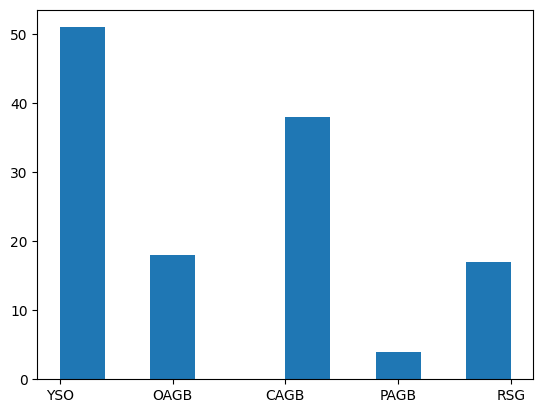

In [59]:
plt.hist(df_smc['SpClass'])